# Implementing Google PageRank

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

The Google probability matrix is as follows:

$$M = \alpha P' + (1 - \alpha)\frac{1}{R}ee^T$$

Where $R$ is the number of web pages, $P' = P + \frac{1}{R}ed^T$, and

$$P_{ij} = \begin{cases} \frac{1}{\deg(j)}, & \text{if link }j \rightarrow i\text{ exists} \\ 0, & \text{otherwise} \end{cases}$$

with

$$d_i = \begin{cases} 1, & \text{if }\deg(i) = 0 \\ 0, & \text{otherwise} \end{cases}$$

and $1 - \alpha$ is the probability we teleport to a random page in order to escape potential closed cycles

In [11]:
# PageRankDense takes in an adjacency matrix G and the 
#   random teleportation weight alpha, and returns 
#   [p, iterations], with p being the pagerank scores 
#   (the probability of landing on the web page) and 
#   iterations being the number of iterations for the 
#   computation to finish. 
def PageRankDense(G, alpha):
    col_sums = np.sum(G, axis=0)
    R = len(G)
    P = np.divide(1, col_sums, where=col_sums != 0) * G
    d = (col_sums == 0).astype(int)
    e = np.ones(R)
    P_prime = P + (1/R) * np.outer(e, d)
    M = alpha * P_prime + (1 - alpha) *  (1 / R)

    tol = 10**(-8)
    p = e / R
    p_prev = np.zeros(R)
    iterations = 0
    while iterations < 1 or np.max(np.abs(p - p_prev)) >= tol:
        p_prev = p
        p = M @ p_prev
        iterations += 1
    
    return p, iterations

Consider this directed graph representing a set of 14 web pages and the links from one web page to another

![Web Pages](web_pages.png)

Let's encode this information in an adjacency matrix G and run the Google page rank algorithm on it

The final pagerank scores are
[0.03885066 0.03993066 0.07381624 0.06248823 0.03288854 0.04002228
 0.063496   0.09892555 0.10291725 0.06380141 0.02088186 0.2137178
 0.11537497 0.03288854]
The list of nodes in decending order of importance are
[12 13  9  8  3 10  7  4  6  2  1 14  5 11]
The number of iterations is 22


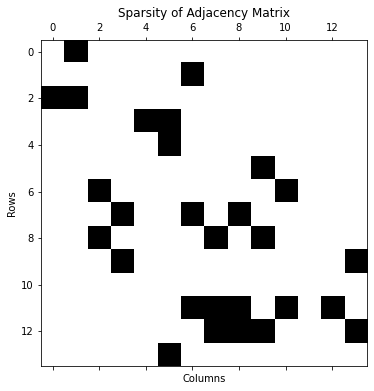

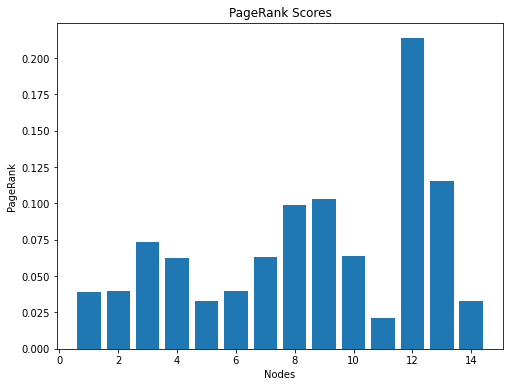

In [12]:
G = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 1 ,1, 1, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

solution_1 = PageRankDense(G, 0.9)
p_1 = solution_1[0]
node_rankings = np.argsort(p_1)[::-1] + 1
print("The final pagerank scores are")
print(p_1)
print("The list of nodes in decending order of importance are")
print(node_rankings)
print("The number of iterations is", solution_1[1])

plt.figure(figsize=(8, 6))
plt.spy(G)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Sparsity of Adjacency Matrix')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(p_1) + 1), p_1)
plt.xlabel('Nodes')
plt.ylabel('PageRank')
plt.title('PageRank Scores')
plt.show()

In order to efficiently handle larger network graphs, we will use the fact that multiplying vectors with sparce matricies can be done efficiently. We can rewrite the Google page rank algorithm as

$$Mp^n = \underbrace{\alpha Pp^n}_{(1)} + \underbrace{\frac{\alpha}{R}ed^Tp^n}_{(2)} + \underbrace{\frac{(1-\alpha)}{R}ee^Tp^n}_{(3)}$$

- $(1)$ Is a sparse matrix-vector multiplication and can be done efficiently
- $(2)$ $d^Tp^n$ is just a scalar, so this is easy
- $(3)$ Since $e^Tp^n = 1$ then this is just $\frac{(1-\alpha)}{R}e$

In [17]:
# PageRankSparse takes in a sparce adjacency matrix Gcsr, the 
#   random teleportation weight alpha, and returns 
#   [p, iterations], with p being the pagerank scores 
#   (the probability of landing on the web page) and 
#   iterations being the number of iterations for the 
#   computation to finish. 
def PageRankSparse(Gcsr, alpha):
    col_sums = np.array(Gcsr.sum(axis=0)).flatten()
    R = Gcsr.shape[0]
    P = Gcsr.multiply(np.divide(1, col_sums, where=col_sums != 0))
    d = (col_sums == 0).astype(int)
    e = np.ones(R)
    
    tol = 10**(-8)
    p = e / R
    p_prev = np.zeros(R)
    iterations = 0
    while iterations < 1 or np.max(np.abs(p - p_prev)) >= tol:
        p_prev = p
        p = alpha * P.dot(p_prev) + (alpha * (d.dot(p_prev)))/R + (1 - alpha)/R
        iterations += 1
    
    return p, iterations

In [21]:
Gcsr_1 = csr_matrix(G)
solution_2 = PageRankSparse(Gcsr_1, 0.9)
print("Dense solution:")
print(solution_1)
print("Sparse solution:")
print(solution_2)

Dense solution:
(array([0.03885066, 0.03993066, 0.07381624, 0.06248823, 0.03288854,
       0.04002228, 0.063496  , 0.09892555, 0.10291725, 0.06380141,
       0.02088186, 0.2137178 , 0.11537497, 0.03288854]), 22)
Sparse solution:
(array([0.03885066, 0.03993066, 0.07381624, 0.06248823, 0.03288854,
       0.04002228, 0.063496  , 0.09892555, 0.10291725, 0.06380141,
       0.02088186, 0.2137178 , 0.11537497, 0.03288854]), 22)


As expected, the sparse and dense solutions are identical. The only difference in the algorithms should be the efficiency, not the result.

Let's test the efficient pagerank implementation on the internet graph data in the file bbc.mat. 

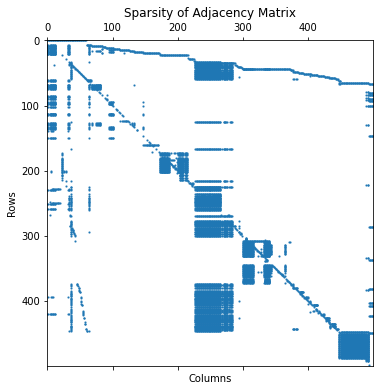

In [22]:
import scipy.io
data = scipy.io.loadmat('bbc.mat')
Gcsr_2 = data['G']
Gcsr_2 = Gcsr_2.transpose() # data uses the reverse adjacency matrix convention.
U = data['U']

plt.figure(figsize=(8, 6))
plt.spy(Gcsr_2, markersize=1)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Sparsity of Adjacency Matrix')
plt.show()

In [24]:
solution_bbc = PageRankSparse(Gcsr_2, 0.9)
p_bbc = solution_bbc[0]
top_website_indices = (np.argsort(p_bbc)[::-1])[:20]

for i in range(len(top_website_indices)):
    print(str(i + 1) + ". " + U[top_website_indices[i]][0][0])
    

1. http://www.bbc.com
2. https://www.bbc.com/news
3. https://www.bbc.co.uk/news
4. http://www.bbcamerica.com
5. http://www.bbc.com/future/story/20181024-the-best-age-to-learn-a-foreign-language
6. http://www.bbc.com/future/story/20181026-how-one-sided-objects-like-a-mobius-strip-work
7. https://www.bbcgoodfood.com
8. https://www.bbc.com/news/business-45939984
9. https://www.bbc.com/news/education-45979234
10. https://www.bbc.com/news/uk-politics-45948282
11. https://www.bbc.com/news/business-45961761
12. http://www.bbc.com/travel/columns/travel-journeys
13. http://bbc.in/2s4bidh
14. http://www.bbc.com/travel
15. http://www.bbc.com/travel/columns/to-the-ends-of-the-earth
16. http://www.bbc.com/travel/columns/welcome-to-our-house
17. http://www.bbc.com/travel/columns/culinary-roots
18. http://bbc.in/2rAX81O
19. https://www.bbc.com/news/world-latin-america-45944164
20. https://www.bbc.com/news/world-europe-45902014
